In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
# using FFTW
using Distributions

# using Pkg
# Pkg.add("FFTA")
using FFTA
using Random
using ReverseDiff
using ForwardDiff


In [27]:
function custom_fftshift2d(A::AbstractMatrix)
    n1, n2 = size(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
    return A[idx1, idx2]
end
function fftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift2d(fft(custom_fftshift2d(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    Ny, Nx = size(B)
    return custom_fftshift2d(bfft(custom_fftshift2d(B)))./(Nx*Ny)
end


ifftnshift (generic function with 1 method)

In [3]:
function Find_Crossing(func, y_point, x)
    N = length(func)
    f = func .- y_point
    x_intercepts = []

    for i in 1:N-1
        if f[i]*f[i+1] < 0
            # Linear interpolation to find the crossing point
            dfdx = (f[i+1] - f[i]) / (x[i+1] - x[i])
            x_intercept = x[i] - f[i]/dfdx
            x_intercepts = push!(x_intercepts, x_intercept)
        end
        
    end
    return x_intercepts
end
function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end

Find_Spacing (generic function with 1 method)

In [ ]:
function Noisy_Image(A::AbstractMatrix{<:Number}, N_electrons::Real ,
    background_noise::Real, kspace=false) 


    image = copy(A)
    if kspace
        # image is assumed to be in reciprocal space and normally ordered
        image = ifftnshift(image)
    end
    image = abs.(image) # image is assumed to be in real-space and real


    image_normalized = N_electrons .* image./sum(image)
    background_noise = rand(Poisson(background_noise), size(image))
    image_poisson =  rand.(Poisson.(image_normalized))
    image_noisy = image_poisson .+ background_noise

    if kspace
        image_noisy = fftnshift(image_noisy)
    return image_noisy
    end

    return image_noisy
end

function Diff_Image(image, c=0.1)
    return @. log1p(c*abs(image))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end
function Autocorrelation_Normalized(image)
    # the image is assumed to be in real space
    Ny, Nx = size(image)
    image_auto = Autocorrelation(image)
    image_auto = image_auto./(Ny*Nx)
    image_auto = image_auto .- sum(image_auto)/(Ny*Nx)
    image_auto = image_auto ./ maximum(abs.(image_auto))
    return image_auto
end

Autocorrelation_Normalized (generic function with 1 method)

In [6]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511.0 #keV
    return hc/sqrt(abs(E*(2*E₀ + E)))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

kmax (generic function with 1 method)

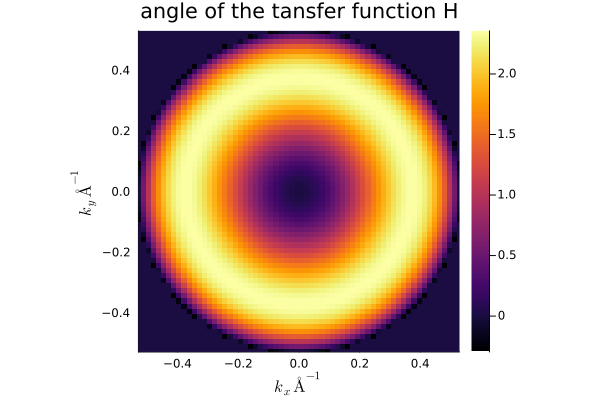

In [51]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms
λ_const = Wavelength(E)

N = 2^6
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2
disk = Float64.(disk)

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = collect(range(-L/2, L/2, N))
y = collect(range(-L/2, L/2, N))


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
# H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
H = @. exp(-1im*χ(k)*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

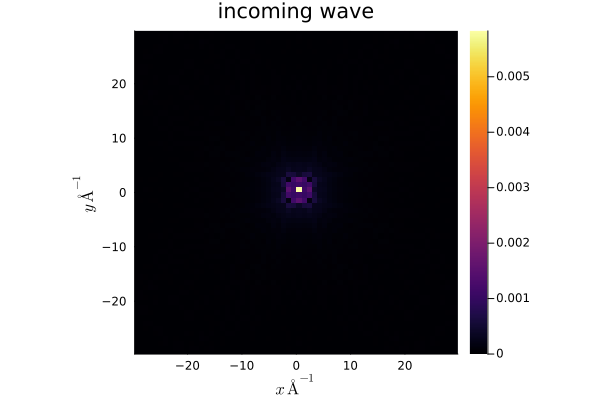

In [48]:
wave_incoming = fill(1/N^2, N, N)
wave_incoming_test = ifftnshift(fftnshift(wave_incoming))

probe = fftnshift(wave_incoming.*H)
heatmap(x,y,Diff_Image(probe), title="incoming wave", 
        xlabel=L"x\, Å^{-1}", ylabel=L"y\, Å^{-1}", aspect_ratio=1)
xlims!(x[1], x[end])
ylims!(y[1], y[end])

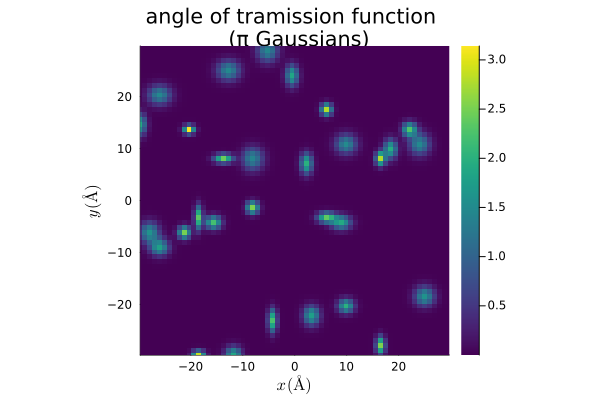

In [42]:
S = 5
σ₊, σ₋ = 7, 7
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
# indices = round.(Int, LinRange(1, N, S))

# for i in indices, j in indices
#     xc = x[i]
#     yc = y[j]
#     phase_real += f(x',y, xc, yc, σ₊, σ₋)
#     phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
# end
xc, yc = 0.0, 0.0
σx, σy = 1, 7
θ_rot = deg2rad(0)
rotatedx = @. cos(θ_rot)*x' + sin(θ_rot)*y
rotatedy = @. -sin(θ_rot)*x' + cos(θ_rot)*y
Random.seed!(1)
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
for i in 1:30
    xc = rand(x)
    yc = rand(y)
    σx, σy = rand(Uniform(0.5, 1.5)), rand(Uniform(0.5, 1.5))
    phase_real += f(rotatedx,rotatedy, xc, yc, σx, σy)
    phase_complex += f(rotatedx,rotatedy, xc, yc, σx, σy) 
end
# phase_real = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)
# phase_complex = f(rotatedx,rotatedy, xc, yc, σx, σy) + f(rotatedx,rotatedy, xc+3, yc, σx, σy)


phase_real = phase_real./maximum(phase_real) *π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real #+ 1im*phase_complex

transmission = @. cis(phase);


fig1 = heatmap(x,y,abs.(phase), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function \n (π Gaussians)")
# vline!([spacing_x], color=:black, lw=2)
# hline!([spacing_y], color=:black, lw=2)

# fig2 = heatmap(x,y,abs.(transmission), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
# xlabel!(L"x\, (Å)")
# ylabel!(L"y\, (Å)")
# xlims!(-L/2, L/2)
# ylims!(-L/2, L/2)

# plot(fig1, fig2, layout=(1,2), size=(800, 400), legend=false)

In [ ]:
Reference_Wave(θ, φ) = @. cispi(2/kmax(E,Cs) * (sin(θ)*cos(φ)*x' + sin(θ)*sin(φ)*y))/N^2
wave_ref = Reference_Wave(0.2, 0).*H
wave_ref = wave_ref./sqrt(sum(abs2.(wave_ref)))
transmission = @. cis(phase);
heatmap(x, y, angle.(wave_ref), aspect_ratio=1, c=:viridis, colorbar=true, axis=true);

In [49]:
raster_shifts = @. cispi(2*(kx' * x' + ky * y))

heatmap(x, y, angle.(raster_shifts), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=true, 
    xlabel="x", 
    ylabel="y");

In [52]:
function Rasters_fft(raster_shifts, wave_object, H)
    Ny, Nx = size(raster_shifts)
    # rasters_fft = Array{ComplexF64}(undef, N, N, N, N)
    common_factor = fftnshift(wave_object .* H)  # element-wise multiplication of tf_wave_fft and H
    rasters_fft = reshape(raster_shifts, Ny, Nx, 1, 1) .* reshape(common_factor, 1, 1, Ny, Nx)
    return rasters_fft
end

Rasters_fft (generic function with 1 method)

In [61]:
wave_obj = transmission.*probe
wave_obj = wave_obj./sqrt(sum(abs2.(wave_obj)))
rasters_fft = Rasters_fft(raster_shifts, wave_obj, H);

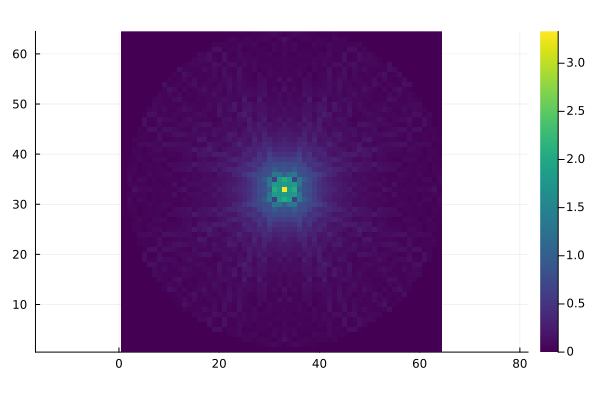

In [62]:
heatmap(Diff_Image.(fftnshift(rasters_fft[10, 30, :, :])), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

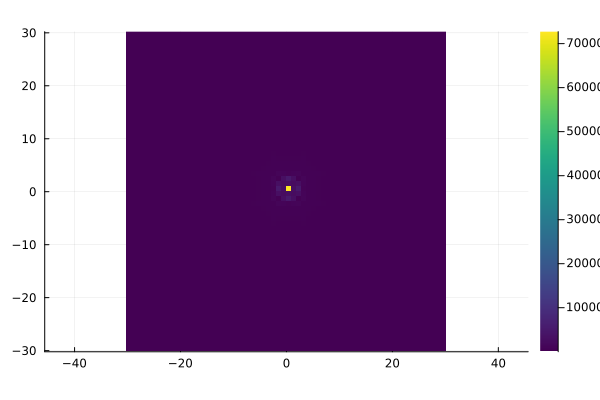

In [65]:

measurement(i,j) = abs2.(fftnshift(wave_ref.+ rasters_fft[i,j,:,:])) 
measurement_noisy(i,j,N_electrons=1e3,B=0.001) = Noisy_Image(measurement(i,j), N_electrons, B)


measurement_fft(i,j) = @. fftnshift(measurement_noisy(i,j))
measurement_autocorr(i,j) = Autocorrelation_Normalized(measurement(i,j))
heatmap(x, y, measurement(10,30), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(x, y, Diff_Image(measurement_fft(1,1)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true) 
# heatmap(kx, ky, Diff_Image(measurement_fft(30,30)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true); 

0


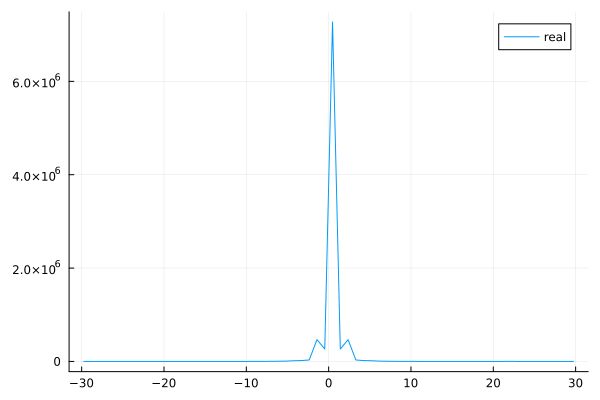

In [79]:
current = measurement(10,30)
println(count(current .== 0.0))
plot(x,(measurement(N÷2+10,40)[N÷2+1,:]), label="real")

In [80]:
# measurement_noised = Array{Float64}(undef, N, N, N, N)
measurement_ideal = Array{Float64}(undef, N, N, N, N)
for i in 1:N, j in 1:N
    # measurement_noised[i,j,:,:] = Noisy_Image(measurement(i,j), 1e2, 0.01)
    measurement_ideal[i,j,:,:] = measurement(i,j)
end
# noised_reshaped = reshape(measurement_noised, N*N*N*N);
ideal_reshaped = reshape(measurement_ideal, N*N*N*N);

In [80]:
println(any(ideal_reshaped .<= 0.0)) 
println(any(isinf.(ideal_reshaped)))
println(any(isnan.(ideal_reshaped)))

false
false
false


In [81]:
# Round to the nearest integer and convert
loglik = logpdf.(Poisson.(ideal_reshaped), round.(Int, ideal_reshaped))

16777216-element Vector{Float64}:
 -4.242592555891754e-28
 -9.438982657441843e-29
 -1.0162500611509685e-27
 -5.727623209970309e-28
 -7.783869278114563e-28
 -4.285486867613147e-28
 -1.0378451284313937e-28
 -3.184039828698309e-28
 -9.152573763552128e-28
 -3.3588218230113393e-29
  ⋮
 -0.00043509341815286737
 -0.00043509341815278616
 -0.0004350934181519019
 -0.00043509341815186486
 -0.0004350934181525685
 -0.00043509341815269867
 -0.0004350934181525553
 -0.00043509341815299444
 -0.0004350934181525558

In [77]:
logpdf(Poisson(5.0), 5.0)    # Returns -Inf


-1.7403021806115442

In [82]:
logpdf.(Poisson.(ideal_reshaped), ideal_reshaped)

16777216-element Vector{Float64}:
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
   ⋮
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf

In [22]:
println(sum(measurement_noised[5,10,:,:]))
println(sum(measurement_ideal[1,1,:,:]))
sum(rand(Poisson(1), size(measurement_noised[5,10,:,:])))

UndefVarError: UndefVarError: `measurement_noised` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

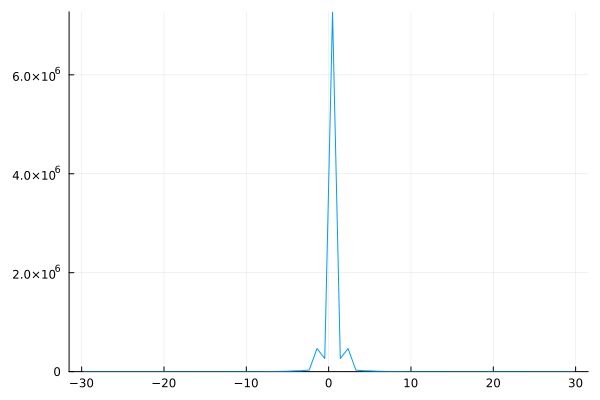

In [86]:
shift = -1
k, l = 25, 3
plot(x,abs.(measurement(k,l)[N÷2-shift,:]), label="", legend=:topright)
ylims!(0,maximum(abs.(measurement(k,l)))*1)

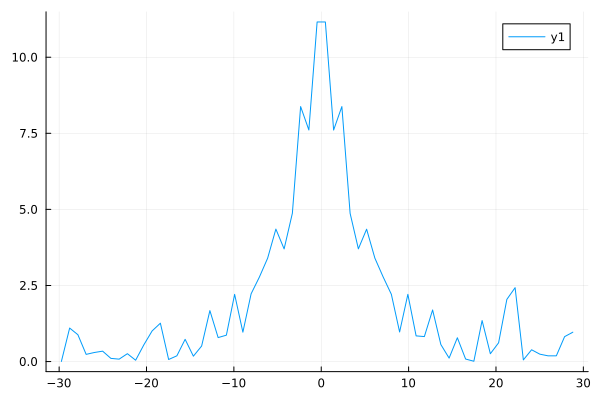

In [85]:
plot(x[1:end-1],Diff_Image(diff(abs.(measurement(k,l)[N÷2-shift,:]))))

In [27]:
plot(x[1:end-2],Diff_Image(diff(diff(abs.(measurement_fft(k,l)[N÷2-shift,:])))));

In [28]:
println(Wavelength(E))

0.019686806700005176


In [109]:
import ChainRulesCore: rrule, NoTangent

# works for ReverseDiff, ForwardDiff and Zygote alike
@inline myabs2(z) = real(z)*real(z) + imag(z)*imag(z)

rrule(::typeof(myabs2), z) = myabs2(z), Δ -> (NoTangent(), 2*Δ*z)


rrule (generic function with 1159 methods)

In [110]:
# χ_array_alloc = Matrix{Float64}(undef, N, N)
function H_transfer(C; 
    k_grid=k,Energy::T=E, 
    bin_disk=disk, 
    λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}


    # returns the transfer function H matrix
    local χ = @. π*λ*k_grid^2*(0.5*Cs*λ^2*k_grid^2 - sqrt(3/2 * Cs * λ))

    return @. cis(-χ*bin_disk)*bin_disk
    # return @. phonycomplex(cos(χ*bin_disk)*bin_disk, sin(-χ*bin_disk)*bin_disk)
end

# function H_transfer(Cs;
#     k_grid=k,Energy::T=E, 
#     bin_disk=disk, 
#     λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}


#     # returns the transfer function H matrix
#     local χ = @. π*λ*k_grid^2*(0.5*Cs*λ^2*k_grid^2 - sqrt(3/2 * Cs * λ))

#     return @. cis(-χ*bin_disk)*bin_disk
#     # return @. phonycomplex(cos(χ*bin_disk)*bin_disk, sin(-χ*bin_disk)*bin_disk)
# end



function wiggle_factor_2ndterm(θ,φ, 
            x::AbstractVector{T}=x, 
            y::AbstractVector{T}=y,
            Energy::T=E, 
            λ::T=λ_const)::AbstractMatrix where {T<:AbstractFloat}

    # arg = @. 2*π*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y)
    return @. cis(2*pi*sin(θ)/λ * (cos(φ)*x' + sin(φ)*y))
    # return @. phonycomplex(cos(arg), sin(arg))
end



function first_term(Cs,θ, φ;
    Energy::T = E,
    x::Vector{T}=x,
    y::Vector{T}=y) where {T<:AbstractFloat}

    # ref_wave = cispi(2/kmax(E,Cs) * (sin(θ)*cos(φ)*x' + sin(θ)*sin(φ)*y))
    arg = @. 2*pi/kmax(Energy,Cs) * sin(θ) *(cos(φ)*x' + sin(φ)*y)/N^2
    wave_ref = @. cis(arg) * H_transfer(Cs)
    norm_factor = sqrt(sum(myabs2.(wave_ref)))
    # wave_ref = wave_ref./sqrt(sum(abs2.(wave_ref)))
    wave_ref = wave_ref./norm_factor
    # wave_ref = ifftnshift(fftnshift(wave_ref).*H_transfer(Cs))

    return wave_ref
    # norm_factor = sqrt(sum(abs2, wave_ref))
    
    # Use a loop-based normalization instead of broadcasting
    # result = similar(wave_ref)
    # for i in eachindex(wave_ref)
    #     result[i] = wave_ref[i] / norm_factor
    # end
    # # result = [wave_ref[i]/norm_factor for i in eachindex(wave_ref)]
    
    # return result
end
# function second_term(Cs::T, θ::T, φ::T) where {T<:AbstractFloat}
#     return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
# end
# function second_term(Cs::T, θ::T, φ::T)::Matrix{Complex{T}} where {T<:AbstractFloat}
# return H_transfer(Cs, θ, φ).*wiggle_factor_2ndterm(θ, φ)
# # return h
# end
function second_term(Cs,ϕ::AbstractMatrix,
    θ,φ)::AbstractMatrix 


    probe = fftnshift(H_transfer(Cs)./N^2)
    transmission = @. cis(ϕ)
    wave_obj = transmission.*probe
    norm_factor = sqrt(sum(myabs2.(wave_obj)))
    wave_obj = wave_obj./norm_factor
    # wave_obj = wave_obj./sqrt(sum(abs2.(wave_obj)))
    # norm_factor = sqrt(sum(abs2, probe))
    # probe_copy = similar(probe)
    # for i in eachindex(probe)
    #     probe_copy[i] = probe[i] / norm_factor
    # end
    # probe_copy = [probe[i]/norm_factor for i in eachindex(probe)]
    # probe = probe./sqrt(sum(abs2,probe))
    return fftnshift(wave_obj.*H_transfer(Cs))
# return fftnshift_custom(@. phonycomplex(cos(ϕ), sin(ϕ))*probe)*H_transfer(Cs) 
end
# probe = ifftnshift(H_transfer(Cs))
# probe = probe./sqrt(sum(abs2.(probe)))
# trasmission = @. exp(1im * phase);
# wave_obj_fft = fftnshift(transmission.*probe).*H_transfer(Cs)

second_term (generic function with 1 method)

second_term (generic function with 2 methods)

In [88]:
using Random
using Turing
using MCMCChains
# using Pigeons
using StatsPlots
using Distributions
using Pkg
# Pkg.add("AdvancedMH")
# Pkg.add("Pigeons")
# using AdvancedMH

In [127]:

using ADTypes
using ReverseDiff
Random.seed!(1)  # For reproducibility
@model function infinite_chain(y, Nx=N, Ny=N)
    # Priors
    # Cs = 1 #mm
    # Cs = Cs * 1e7 #convert to Angstroms
    # A ~ truncated(Normal(100, 15), 10, 200)
    # B ~ Uniform(0,0.1)
    Cs ~ Normal(1e7, 3e6)
    θ ~ truncated(Normal(0.1, 1), 0, 1)
    φ ~ Normal(0, 0.1)
    ϕ ~ filldist(Uniform(0,π), Ny, Nx)


    # Likelihood
    wave_ref = first_term(Cs, θ, φ)
    wave_obj = reshape(wiggle_factor_2ndterm(θ,φ),Ny,Nx,1,1 ) .+ 
            reshape(second_term(Cs, ϕ, θ, φ), 1, 1, Ny, Nx)
    println(size(wave_obj))
    println(size(wave_ref))
    # measurement_ideal = Array{Any}(undef, N, N, N, N)
    # for i in 1:Ny, j in 1:Nx
    #     measurement_ideal[i,j,:,:] = abs2.(fftnshift_custom(wave_ref .+ wave_obj[i,j,:,:]))
    # end
    # measurement_ideal = [myabs2.(fftnshift(wave_ref.+ wave_obj[i,j,:,:])) 
    #                  for i in 1:Ny, j in 1:Nx]
    @assert size(wave_ref) == size((wave_obj[1, 1, :, :])) "mismatch"
    # measurement_ideal = [myabs2.(fftnshift(wave_ref .+ wave_obj[i, j,:,:]))
    #                  for i in 1:Ny, j in 1:Nx]
    @views measurement_ideal = [myabs2.(fftnshift(wave_ref .+ view(wave_obj, i, j, :, :)))
                                for i in 1:Ny, j in 1:Nx]
    @assert all(size.(measurement_ideal) .== (Ny, Nx))   # every slice is 64×64

    # Use a list comprehension to create a flat vector
    # flattened_measurements = vcat([vec(abs2.(fftnshift(wave_ref.+ wave_obj[i,j,:,:]))) 
    # for i in 1:Ny, j in 1:Nx]...)

    # Apply Poisson to scalar values
    # y ~ arraydist(Poisson.(flattened_measurements))
    flattened_measurements = vcat(map(x -> vec(x), vec(measurement_ideal))...)
    # flattened_measurements = collect(Iterators.flatten(measurement_ideal))
    # @views measurement_ideal = mapreduce(abs2, vcat,
    # fftnshift.(wave_ref .+ wave_obj))
    y ~ arraydist(Poisson.(flattened_measurements))
    # y ~ arraydist(Poisson.(vec(measurement_ideal)))
    
end
# Generate synthetic data
n = 2

# Fit the model
initial_params = (Cs=1e7, θ=0.1, φ=0.0, ϕ=phase)
model = infinite_chain(round.(Int, ideal_reshaped))
# sampler = Turing.SGLD(; stepsize=0.01, adtype=AutoForwardDiff())
# sampler = Turing.NUTS(max_depth=8; adtype=AutoReverseDiff(true))
# using Zygote
# sampler = Turing.NUTS(max_depth=8; adtype=AutoZygote())
sampler = Turing.MH() # Metropolis-Hastings



chain = sample(model, sampler, n, initial_params=initial_params, progress=true)

# chain = sample(model, sampler, MCMCThreads(), n, 8, progress=true)
# Plot the results
# plot(x,y)

(64, 64, 64, 64)
(64, 64)


MethodError: MethodError: no method matching +(::Matrix{ComplexF64}, ::ComplexF64)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar
The function `+` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:596
  +(!Matched::SciMLOperators.IdentityOperator, ::Number)
   @ SciMLOperators ~/.julia/packages/SciMLOperators/2UPBq/src/basic.jl:386
  +(!Matched::ChainRulesCore.ZeroTangent, ::Any)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/U6wNx/src/tangent_arithmetic.jl:99
  ...


In [117]:
result = maximum_a_posteriori(model)
# result_mle = maximum_likelihood(model)

(64, 64, 64, 64)
(64, 64)


MethodError: MethodError: no method matching +(::Matrix{ComplexF64}, ::ComplexF64)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar
The function `+` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:596
  +(!Matched::SciMLOperators.IdentityOperator, ::Number)
   @ SciMLOperators ~/.julia/packages/SciMLOperators/2UPBq/src/basic.jl:386
  +(!Matched::ChainRulesCore.ZeroTangent, ::Any)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/U6wNx/src/tangent_arithmetic.jl:99
  ...


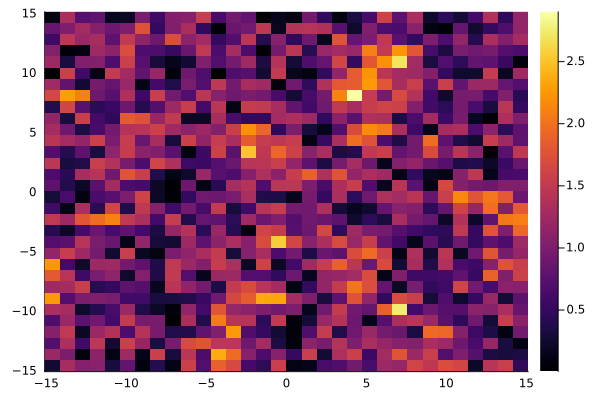

In [119]:
# If you're trying to reshape the phi parameters into a 2D field
phi_params = sum(Array(chain[1:end, 4:end, :]), dims=1)/size(chain, 1)
# phi_matrix = reshape(phi_params, N, N)  # Reshape to N×N grid
heatmap(x, y, phi_params)

In [103]:
A = chain[end,4:end,:]
# ϕ = reshape(A[5:end], N, N)
heatmap(x,y,A)

ErrorException: Cannot convert Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, @NamedTuple{parameters::Vector{Symbol}, internals::Vector{Symbol}}, @NamedTuple{varname_to_symbol::OrderedDict{AbstractPPL.VarName, Symbol}, start_time::Float64, stop_time::Float64}} to series data for plotting

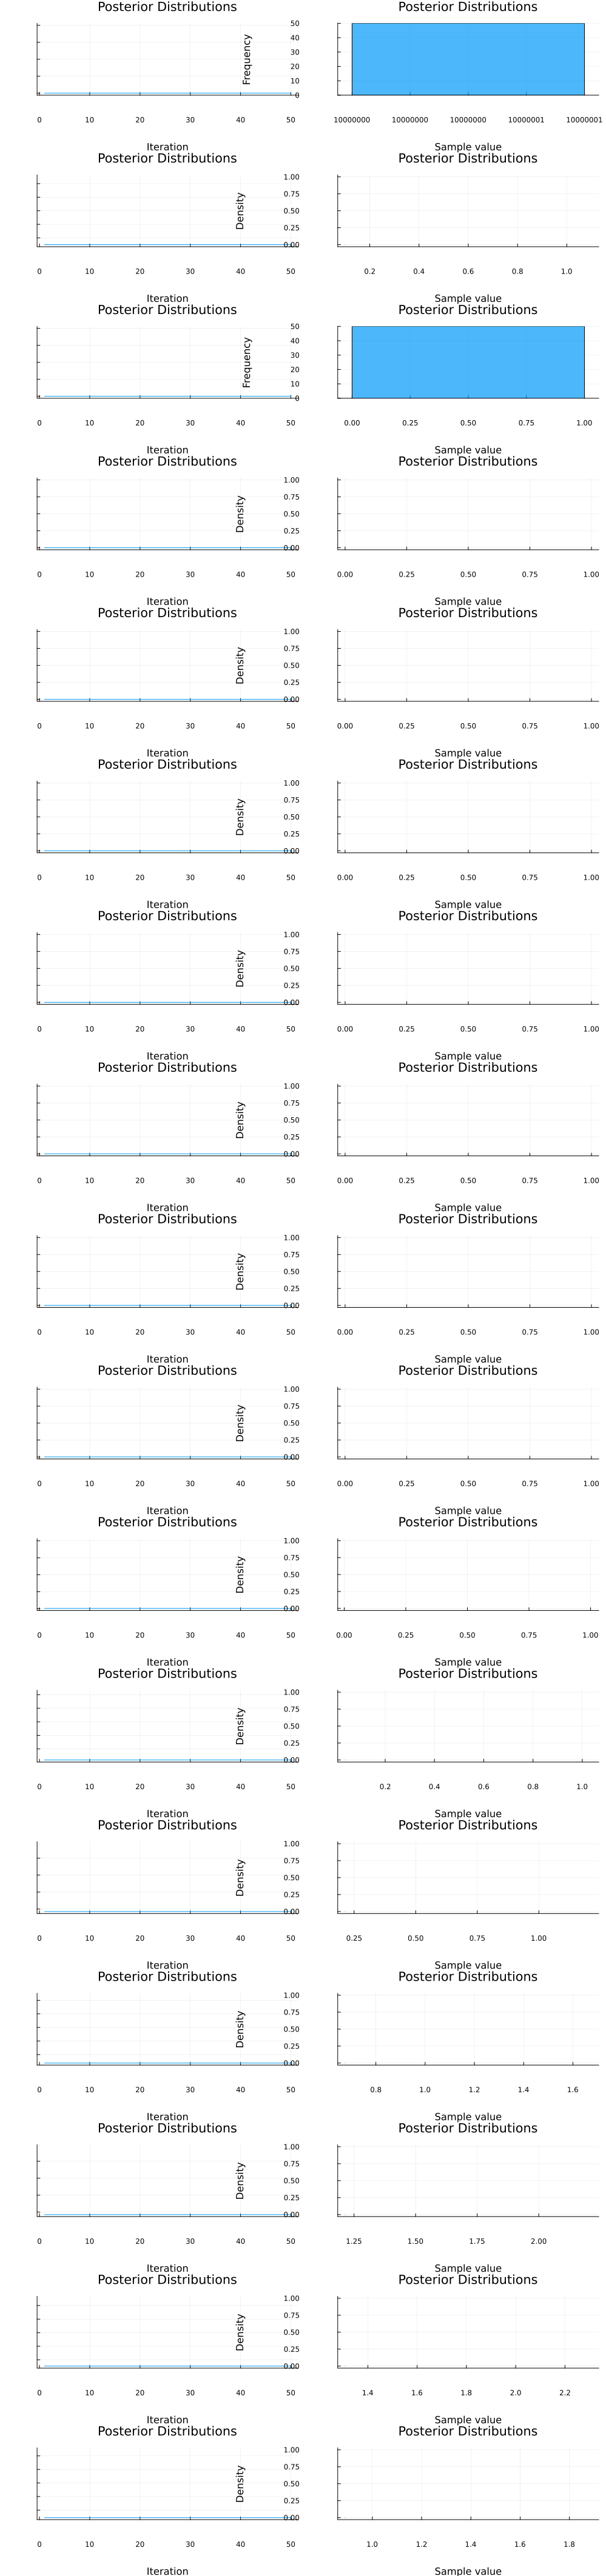

In [43]:
plot(chain[:,1:17,:], title="Posterior Distributions", legend=false)

In [34]:
plot(samples, title="Posterior Distributions", legend=false)

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [35]:
using Random, Distributions

In [36]:
# using Pkg
#using MCMCChains
using MCMCChains
using AdaptiveMCMC




λ_model_alloc = Array{Float64,4}(undef, N, N, N, N)
function log_likelihood(x::AbstractVector{T}, 
    data::typeof(measurement_noised)=measurement_ideal, 
    Nx=N, Ny=N, λ_model::typeof(λ_model_alloc)=λ_model_alloc)::T where {T<:AbstractFloat}

    
    B_shift, B_scale = 0.1, 0.1
    B = B_shift + B_scale*x[end]
    B_logpdf = logpdf(truncated(Normal(B_shift, B_scale), 0, 2), B)
    B_logpdf += log10(B_scale)

    Cs_shift, Cs_scale = 1e7, 3e6
    Cs = Cs_shift + Cs_scale*x[end-1]
    Cs_logpdf = logpdf(truncated(Normal(Cs_shift, Cs_scale), 0, Inf), Cs)
    Cs_logpdf += log10(Cs_scale)

    θ_shift, θ_scale = 0.1, 0.1
    θ = θ_shift + θ_scale*x[end-2]
    θ_logpdf = logpdf(truncated(Normal(θ_shift, θ_scale), 0, 1), θ)
    θ_logpdf += log10(θ_scale)

    φ_shift, φ_scale = 0.0, 0.1
    φ = φ_shift + φ_scale*x[end-3]
    φ_logpdf = logpdf(Normal(φ_shift, φ_scale), φ)
    φ_logpdf += log10(φ_scale)

    
    # ϕ = reshape(x[1:Nx*Ny], Ny, Nx)
    # ϕ_logpdf = sum(logpdf.(Uniform(-0.1, π/2 + 0.1), ϕ))
    ϕ_lower, ϕ_upper = -0.1, π/2 + 0.1
    rawϕ = view(x, 1:Nx*Ny)
    ϕ = ϕ_lower .+ (ϕ_upper-ϕ_lower).*cdf.(Normal(), rawϕ)
    ϕ = reshape(ϕ, Ny, Nx)
    ϕ_logpdf = -Nx*Ny*log10(ϕ_upper-ϕ_lower)   # constant Jacobian term
    # if !isfinite(B_logpdf) || !isfinite(Cs_logpdf) || !isfinite(θ_logpdf) || !isfinite(φ_logpdf) == 0 || ϕ_logpdf == 0
    #     return -Inf
    # end
    
    
    λ_model .= abs2.(
        reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
                reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
                .+ B
    
    return sum(data.*log10.(λ_model) - λ_model) + B_logpdf + Cs_logpdf + θ_logpdf + φ_logpdf + ϕ_logpdf
end




function parallel_rwm()
    Ny, Nx = N, N
    x0 = zeros(Ny*Nx + 4)
    # x0[end] = 0.1
    # x0[end-1] = 0.0
    # x0[end-2] = 0.1
    # x0[end-3] = 0.0
    n = 50
    thining = 3
    burn_in = n÷2
    interations = (n-burn_in)÷thining + 1
    n_chains = 10

    rwm_chains_parallel = Array{Float64, 3}(undef, interations, length(x0), n_chains)
    Threads.@threads for i in 1:n_chains
        rwm_chains_parallel[:, :, i] = Transpose(adaptive_rwm(x0, log_likelihood, n; 
                                                thin=thining, L=2, b=burn_in,
                                                algorithm=:asm, 
                                                swaps =:nonrev)[1])
    end
    return rwm_chains_parallel
end
rwm_chains_parallel = parallel_rwm();



UndefVarError: UndefVarError: `measurement_noised` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [37]:
# using Pkg
#using MCMCChains
using MCMCChains
using AdaptiveMCMC




λ_model_alloc = Array{Float64,4}(undef, N, N, N, N)
function log_likelihood(x::AbstractVector{T}, 
    data::typeof(measurement_noised)=measurement_ideal, 
    Nx=N, Ny=N, λ_model::typeof(λ_model_alloc)=λ_model_alloc)::T where {T<:AbstractFloat}

    
    B = x[end]
    Cs = x[end-1]
    θ = x[end-2]
    φ = x[end-3]

    B_logpdf = logpdf(truncated(Normal(0.1, 0.1), 0, 2), B)
    
    Cs_logpdf = logpdf(truncated(Normal(1e7, 1e6), 0, Inf), Cs)
    
    θ_logpdf = logpdf(truncated(Normal(0.1, 0.1), 0, 1), θ)
    
    φ_logpdf = logpdf(Normal(0.1, 0.1), φ)
    

    
    ϕ = reshape(x[1:Nx*Ny], Ny, Nx)
    ϕ_logpdf = sum(logpdf.(Uniform(-0.1, π/2 + 0.1), ϕ))
    
    
    
    
    λ_model .= abs2.(
        reshape(first_term(Cs, ϕ),Ny,Nx,1,1 ) .+ 
                reshape(second_term(Cs, θ, φ), 1, 1, Ny, Nx)) 
                .+ B
    
    return sum(data.*log10.(λ_model) - λ_model) + B_logpdf + Cs_logpdf + θ_logpdf + φ_logpdf + ϕ_logpdf
end




function parallel_rwm()
    Ny, Nx = N, N
    x0 = zeros(Ny*Nx + 4)
    # x0[end] = 0.1
    # x0[end-1] = 0.0
    # x0[end-2] = 0.1
    # x0[end-3] = 0.0
    n = 50
    thining = 3
    burn_in = n÷2
    interations = (n-burn_in)÷thining + 1
    n_chains = 10

    rwm_chains_parallel = Array{Float64, 3}(undef, interations, length(x0), n_chains)
    Threads.@threads for i in 1:n_chains
        rwm_chains_parallel[:, :, i] = Transpose(adaptive_rwm(x0, log_likelihood, n; 
                                                thin=thining, L=2, b=burn_in,
                                                algorithm=:asm, 
                                                swaps =:nonrev)[1])
    end
    return rwm_chains_parallel
end
rwm_chains_parallel = parallel_rwm();



UndefVarError: UndefVarError: `measurement_noised` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [38]:
@benchmark log_likelihood(x0)

LoadError: LoadError: UndefVarError: `@benchmark` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at /home/nicolas/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X51sZmlsZQ==.jl:1

In [39]:
@benchmark log_likelihood(zeros(N*N+4))

LoadError: LoadError: UndefVarError: `@benchmark` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at /home/nicolas/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X52sZmlsZQ==.jl:1

In [40]:
ϕ = reshape(x0[1:Nx*Ny], Ny, Nx)
φ = x0[end-3]      
θ = abs(x0[end-2])
Cs = abs(x0[end-1])
# @btime first_term(Cs, ϕ);

UndefVarError: UndefVarError: `x0` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [41]:
samples = Chains(rwm_chains_parallel)

UndefVarError: UndefVarError: `rwm_chains_parallel` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [42]:
plot(samples[:,1:4,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")
# plot(samples[:,end-3:end,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [43]:
plot(samples[:,end÷2:end÷2+5,:], labels=["B", "Cs", "θ", "φ"], title="Posterior Distributions", xlabel="Parameter Value", ylabel="Density")

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [44]:
summaries, quantiles = describe(samples)

UndefVarError: UndefVarError: `samples` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [45]:
summaries

UndefVarError: UndefVarError: `summaries` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [46]:
plot(chain[:,10:14,:])

UndefVarError: UndefVarError: `chain` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing IterTools in the current active module Main

In [47]:
# Suppose you want the first element of φ for each sample:
plot(chain[:, ["B", "Cs", "θ", "φ"], :], seriestype=:trace, title="Trace Plots")# plot(chain, seriestype=:density, title="Density Plots")


UndefVarError: UndefVarError: `chain` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing IterTools in the current active module Main